In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Data and Parameters

In [2]:
# 1. LOAD DATA (Global multi-style factor premia)

# Put the Excel file in the same folder as your notebook,
file = "AQR_Century of Factor Premia.xlsx"

# In this file, the header row for "Global Factors" is Excel row 19 -> header=18
df = pd.read_excel(file, sheet_name="Global Factors", header=18)

# First column is the date; rename and make it the index
df = df.rename(columns={df.columns[0]: "Date"})
df["Date"] = pd.to_datetime(df["Date"])
df = df.dropna(subset=["Date"]).set_index("Date").sort_index()

# Drop rows that are completely empty (towards the end of the sheet)
df = df.dropna(how="all")

# Long/short factor premia = first 4 columns
factor_cols = df.columns[:4]
# Equity market (not used for MVO here) = 5th column
benchmark_col = df.columns[4]

factors = df[factor_cols].dropna()

#test
"""print("Factors used:", list(factor_cols))
print("Sample from", factors.index.min(), "to", factors.index.max(),
      "N =", len(factors))"""

'print("Factors used:", list(factor_cols))\nprint("Sample from", factors.index.min(), "to", factors.index.max(),\n      "N =", len(factors))'

In [3]:
# 2. Covariance

# Monthly expected returns 
mu_m = factors.mean()        
# Monthly covariance matrix
cov_matrix = factors.cov()   

# mu and cov_matrix in arrays for calculation
mu = np.array(mu_m)
cov = np.array(cov_matrix)

print(cov_matrix, mu_m)

                            Equity indices Multi-style  \
Equity indices Multi-style                    0.000220   
Fixed income Multi-style                      0.000011   
Currencies Multi-style                        0.000005   
Commodities Multi-style                       0.000016   

                            Fixed income Multi-style  Currencies Multi-style  \
Equity indices Multi-style                  0.000011                0.000005   
Fixed income Multi-style                    0.000036                0.000010   
Currencies Multi-style                      0.000010                0.000113   
Commodities Multi-style                     0.000009                0.000021   

                            Commodities Multi-style  
Equity indices Multi-style                 0.000016  
Fixed income Multi-style                   0.000009  
Currencies Multi-style                     0.000021  
Commodities Multi-style                    0.000740   Equity indices Multi-style    0.002823

# Tangency Portfolio

In [4]:
# 3. Create the TANGENCY PORTFOLIO (γ = 1) – “Optimal weights”
w_mvo = np.linalg.solve(cov, mu)
w_mvo_norm = w_mvo/ w_mvo.sum()

print(pd.Series(w_mvo_norm, index=factor_cols))

Equity indices Multi-style    0.263965
Fixed income Multi-style      0.234444
Currencies Multi-style        0.296365
Commodities Multi-style       0.205226
dtype: float64


In [5]:
# 4. calculate stats 

ret_mvo = w_mvo_norm.T @ mu 
var_mvo = w_mvo_norm.T @ cov @ w_mvo_norm
std_mvo = np.sqrt(var_mvo)

ann_ret_mvo = (1 + ret_mvo)**12 -1
ann_std_mvo = std_mvo * np.sqrt(12)

monthly_sharpe = ret_mvo / std_mvo
annual_sharpe = ann_ret_mvo / ann_std_mvo
utility  = ret_mvo - 0.5 * 1 * var_mvo 

print(pd.DataFrame({
    "monthly return MVO": ret_mvo,
    "monthly var_mvo": var_mvo,
    "monthly vol_mvo": std_mvo,
    "Annual return MVO" : ann_ret_mvo,
    "Annual volatility" : ann_std_mvo
}, index=factor_cols))

print(pd.DataFrame({
    "monthly sharpe ratio" : monthly_sharpe,
    "annual sharpe ratio" : annual_sharpe,
    "utility function" : utility
    }, index=factor_cols))

                            monthly return MVO  monthly var_mvo  \
Equity indices Multi-style            0.002899         0.000067   
Fixed income Multi-style              0.002899         0.000067   
Currencies Multi-style                0.002899         0.000067   
Commodities Multi-style               0.002899         0.000067   

                            monthly vol_mvo  Annual return MVO  \
Equity indices Multi-style         0.008188           0.035342   
Fixed income Multi-style           0.008188           0.035342   
Currencies Multi-style             0.008188           0.035342   
Commodities Multi-style            0.008188           0.035342   

                            Annual volatility  
Equity indices Multi-style           0.028364  
Fixed income Multi-style             0.028364  
Currencies Multi-style               0.028364  
Commodities Multi-style              0.028364  
                            monthly sharpe ratio  annual sharpe ratio  \
Equity indices Multi

# Risk aversion level

In [ ]:
# 5. Settle risk aversion 

aversion_lvls = list(range(1, 40)) #We test until 40 risk aversion coeff

results = []

# Constrains
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
bounds = [(-1, 1)] * len(mu)   # long/short allowed
w0 = np.ones(len(mu)) / len(mu)

from scipy.optimize import minimize

for aversion_level in aversion_lvls:

    def utility_to_minimize(w):
        port_ret = w @ mu
        port_var = w @ cov @ w
        return -(port_ret - 0.5 * aversion_level * port_var)  # maximise U

    opt = minimize(utility_to_minimize, w0, bounds=bounds, constraints=constraints)
    w_opt = opt.x

    # Monthly stats
    ret_m = float(w_opt @ mu)
    var_m = float(w_opt @ cov @ w_opt)
    sd_m = math.sqrt(var_m)

    # Annualised
    ret_ann = (1 + ret_m)**12 - 1
    sd_ann  = sd_m * math.sqrt(12)

    # Ratios
    sharpe_m = ret_m / sd_m
    sharpe_ann = ret_ann / sd_ann if sd_ann != 0 else np.nan

    results.append({
        "aversion_level": aversion_level,
        "Return_m": ret_m,
        "Variance_m": var_m,
        "SD_m": sd_m,
        "Return_ann": ret_ann,
        "SD_ann": sd_ann,
        "Sharpe_m": sharpe_m,
        "Sharpe_ann": sharpe_ann,
        "Utility": ret_m - 0.5* aversion_level * var_m,
        "Weights": w_opt
    })

df_aversion = pd.DataFrame(results)
print(df_aversion)


    aversion_level  Return_m  Variance_m      SD_m  Return_ann    SD_ann  \
0                1  0.009202    0.000976  0.031237    0.116183  0.108208   
1                2  0.009195    0.000973  0.031197    0.116097  0.108069   
2                3  0.009188    0.000971  0.031155    0.116006  0.107923   
3                4  0.009181    0.000968  0.031110    0.115910  0.107770   
4                5  0.009173    0.000965  0.031064    0.115808  0.107609   
5                6  0.009165    0.000962  0.031014    0.115697  0.107437   
6                7  0.009156    0.000959  0.030962    0.115579  0.107256   
7                8  0.009001    0.000918  0.030300    0.113525  0.104963   
8                9  0.008618    0.000827  0.028757    0.108460  0.099617   
9               10  0.008004    0.000698  0.026414    0.100389  0.091502   
10              11  0.007403    0.000583  0.024136    0.092543  0.083609   
11              12  0.006878    0.000491  0.022157    0.085728  0.076753   
12          

In [7]:
# check only the weights

df_aversion["Weights"].apply(lambda w: np.round(w, 4))

0           [0.9743, -1.0, 0.0257, 1.0]
1             [0.968, -1.0, 0.032, 1.0]
2           [0.9614, -1.0, 0.0386, 1.0]
3           [0.9543, -1.0, 0.0457, 1.0]
4           [0.9469, -1.0, 0.0531, 1.0]
5           [0.9388, -1.0, 0.0612, 1.0]
6           [0.9301, -1.0, 0.0699, 1.0]
7         [0.9401, -1.0, 0.091, 0.9689]
8        [0.9857, -1.0, 0.1264, 0.8879]
9      [0.9283, -0.885, 0.1496, 0.8071]
10     [0.851, -0.7538, 0.1669, 0.7359]
11     [0.7752, -0.6315, 0.1794, 0.677]
12     [0.7319, -0.5515, 0.193, 0.6266]
13    [0.6851, -0.4734, 0.2028, 0.5855]
14    [0.6466, -0.4063, 0.2145, 0.5452]
15    [0.6201, -0.3596, 0.2222, 0.5173]
16     [0.2496, 0.0806, 0.1746, 0.4952]
17      [0.2514, 0.096, 0.1831, 0.4695]
18     [0.2531, 0.1098, 0.1907, 0.4465]
19      [0.2546, 0.122, 0.1975, 0.4259]
20     [0.2561, 0.1331, 0.2036, 0.4072]
21      [0.2574, 0.143, 0.2093, 0.3903]
22      [0.2587, 0.1519, 0.2144, 0.375]
23      [0.2599, 0.1599, 0.2191, 0.361]
24     [0.2612, 0.1671, 0.2234, 0.3483]


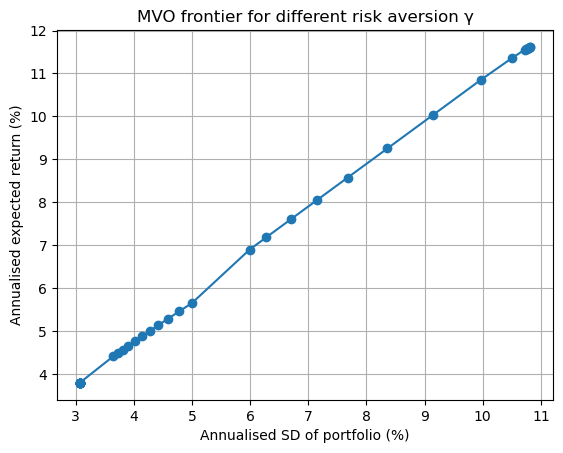

In [8]:
# 6. Plot the efficient frontier

frontier_sd = df_aversion["SD_ann"].values * 100      # in %
frontier_ret = df_aversion["Return_ann"].values * 100 # in %

plt.figure()
plt.plot(frontier_sd, frontier_ret, marker="o")
plt.xlabel("Annualised SD of portfolio (%)")
plt.ylabel("Annualised expected return (%)")
plt.title("MVO frontier for different risk aversion γ")
plt.grid(True)
plt.show()

#The efficient frontier for a long/short portfolio isn't curvy 


# Market-MVO with a 3% TE

In [9]:
# Choose the risk aversion level for the factor MVO portfolio
aversion_choice = 16  # you can change this gamma if you want another point on the frontier

# Retrieve the optimal weights for this risk aversion level from df_aversion
row_choice = df_aversion.loc[df_aversion["aversion_level"] == aversion_choice].iloc[0]
w_factors_choice = row_choice["Weights"]  # numpy array of factor weights

print(f"Factor weights for aversion level = {aversion_choice}:")
print(pd.Series(w_factors_choice, index=factors.columns).round(4))

Factor weights for aversion level = 16:
Equity indices Multi-style    0.6201
Fixed income Multi-style     -0.3596
Currencies Multi-style        0.2222
Commodities Multi-style       0.5173
dtype: float64


In [10]:
# Build factor portfolio and benchmark returns

# Build the monthly returns of the selected factor portfolio
r_factor = factors.values @ w_factors_choice
r_factor = pd.Series(r_factor, index=factors.index, name="Selected_factor")

# Get the market (benchmark) monthly returns over the same dates
r_market = df[benchmark_col].loc[factors.index]
r_bench = r_market  # alias for clarity

# Calculate tracking error

# Monthly tracking error if we take the factor portfolio with lambda = 1
te_m_1 = r_factor.std(ddof=1)      # monthly TE
te_a_1 = te_m_1 * math.sqrt(12)   # annualised TE

# Solve for lambda given a TE target 

target_te_a = 0.03   # 3% annual tracking error target

# Since TE scales linearly with lambda, we can rescale the factor sleeve:
lambda_scale = target_te_a / te_a_1


print("\nAnnualised TE of the factor portfolio (λ = 1):", te_a_1)
print("Lambda (scale on the factor portfolio) for 3% TE:", lambda_scale)



Annualised TE of the factor portfolio (λ = 1): 0.05989322529888249
Lambda (scale on the factor portfolio) for 3% TE: 0.5008913754484308


## Formula : 
### 1⋅r market +λ⋅r factor

In [11]:

# Integrated portfolio: Market + λ * Factor sleeve
# The integrated portfolio is an overlay portfolio so we have 100% in the market + lambda 
r_int = r_market + lambda_scale * r_factor
r_int.name = "Integrated_pf"

# Active returns vs benchmark (should equal lambda * r_factor)
r_active = r_int - r_market
r_active.name = "Active_return"

# Check TE of the final integrated portfolio
te_m = r_active.std(ddof=1)            # monthly TE
te_a = te_m * math.sqrt(12)           # annualised TE

# Active mean return (monthly)
mu_active_m = r_active.mean()
# Approximate annualised active return (arithmetic-style)
mu_active_a = 12 * mu_active_m

# Information Ratio = annualised active return / annualised TE
IR = mu_active_a / te_a

print("\n Market + Factors summary (TE-constrained) ")
print("Final annualised TE:", te_a)
print("Annualised active return (approx):", mu_active_a)
print("Information Ratio:", IR)



 Market + Factors summary (TE-constrained) 
Final annualised TE: 0.02999999999999996
Annualised active return (approx): 0.033494627630226204
Information Ratio: 1.1164875876742082


In [12]:
def ann_stats(returns_m):
    """
    Compute annualised statistics from monthly returns:
    - mu_ann : annualised return (geometric-style)
    - sd_ann : annualised volatility
    - Sharpe_ann : annualised Sharpe ratio with zero risk-free (simple version)
    """
    mu_m = returns_m.mean()
    sd_m = returns_m.std(ddof=1)
    
    # Geometric-style annualisation for returns
    mu_a = (1 + mu_m)**12 - 1
    sd_a = sd_m * math.sqrt(12)
    
    sharpe_a = mu_a / sd_a if sd_a != 0 else float("nan")
    return mu_a, sd_a, sharpe_a

In [13]:
bm_mu_a, bm_sd_a, bm_sh_a = ann_stats(r_bench)
int_mu_a, int_sd_a, int_sh_a = ann_stats(r_int)

print("\n--- Benchmark ---")
print("Annualised return:", bm_mu_a)
print("Annualised vol   :", bm_sd_a)
print("Annualised Sharpe:", bm_sh_a)

print("\n--- Integrated Market + Factors portfolio ---")
print("Annualised return:", int_mu_a)
print("Annualised vol   :", int_sd_a)
print("Annualised Sharpe:", int_sh_a)
print("Annualised outperformance vs benchmark:", int_mu_a - bm_mu_a)
print("Information Ratio (reminder):", IR)


--- Benchmark ---
Annualised return: 0.06799518372913949
Annualised vol   : 0.14166873922032058
Annualised Sharpe: 0.4799589810945846

--- Integrated Market + Factors portfolio ---
Annualised return: 0.10411995316758471
Annualised vol   : 0.14440808058644067
Annualised Sharpe: 0.7210119596130214
Annualised outperformance vs benchmark: 0.036124769438445226
Information Ratio (reminder): 1.1164875876742082


In [14]:
assets = ["Market"] + list(factors.columns)

weights_benchmark = [1.0] + [0.0] * len(factors.columns)
weights_mvo_factor = [0.0] + list(w_factors_choice)
weights_integrated = [1.0] + list(lambda_scale * w_factors_choice)

weights_df = pd.DataFrame(
    {
        "Benchmark": weights_benchmark,
        "Factor MVO": weights_mvo_factor,
        "Integrated (overlay)": weights_integrated,
    },
    index=assets,
)

print(weights_df.round(4))


                            Benchmark  Factor MVO  Integrated (overlay)
Market                            1.0      0.0000                1.0000
Equity indices Multi-style        0.0      0.6201                0.3106
Fixed income Multi-style          0.0     -0.3596               -0.1801
Currencies Multi-style            0.0      0.2222                0.1113
Commodities Multi-style           0.0      0.5173                0.2591
